# Example of transfer learning vision agent

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import copy

import torch
import imageio
import gymnasium as gym
from torchvision import models
import matplotlib.pyplot as plt

from transfer_agent import TransferDeepQ

In [2]:
environment = gym.make('ALE/Tetris-v5', render_mode="rgb_array",
                       obs_type="rgb", frameskip=4, repeat_action_probability=0.25)
environment.metadata["render_fps"] = 30

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


## Parameters

|Parameter|Description|
|---------|-----------|
| SHAPE | input shape of the network (batch, channels, height, width) |
| DISCOUNT | discount rate for rewards |
| GAMMA | discount rate for Q-learning |
| EXPLORATION_RATE | initial exploration rate |
| EXPLORATION_MIN | minimum exploration rate |
| EXPLORATION_STEPS | number of games to decay exploration rate from `RATE` to `MIN` |
| MINIBATCH | size of the minibatch |
| TRAIN_EVERY | train the network every `n` games |
| START_TRAINING_AT | start training after n games |
| REMEMBER_ALL | only remember games with rewards |
| MEMORY | size of the agents internal memory |
| RESET_Q_EVERY | update target-network every `n` games |

In [3]:
GAMES = 50
SHAPE = (1, 3, 210, 160)

DISCOUNT = 0.98
GAMMA = 0.99

EXPLORATION_RATE = 0.1
EXPLORATION_MIN = 0.01
EXPLORATION_STEPS = 100

MINIBATCH = 32
TRAIN_EVERY = 5
START_TRAINING_AT = 45

REMEMBER_ALL = False
MEMORY = 150
RESET_Q_EVERY = 100

OPTIMIZER = {
    "optimizer": torch.optim.Adam,
    "lr": 0.001,
    "hyperparameters": {}
}

## Pre-trained model

In [4]:
preprocess = models.ResNet18_Weights.DEFAULT.transforms()
network = models.resnet18(weights=models.ResNet18_Weights.DEFAULT, progress=False)

## Agent definition

In [5]:
value_agent = TransferDeepQ(
    transfer={"network": network, "preprocess": preprocess},
    actions=5, optimizer=OPTIMIZER,

    batch_size=MINIBATCH,

    other={
        "discount": DISCOUNT, "gamma": GAMMA,

        "memory": MEMORY,

        "exploration_rate": EXPLORATION_RATE,
        "exploration_steps": EXPLORATION_STEPS,
        "exploration_min": EXPLORATION_MIN
    }
)

_value_agent = copy.deepcopy(value_agent.network)

## Training

In [6]:
CHECKPOINT = GAMES // 10
METRICS = {
    "steps": torch.zeros(GAMES),
    "losses": torch.zeros(GAMES // TRAIN_EVERY),
    "exploration": torch.zeros(GAMES),
    "rewards": torch.zeros(GAMES)
}

In [7]:
TRAINING = False

start = time.time()
for game in range(1, GAMES + 1):

    if not TRAINING and game >= START_TRAINING_AT:
        print("Starting training")
        TRAINING = True

    state = torch.tensor(environment.reset()[0], dtype=torch.float32).view(SHAPE)
    TERMINATED = TRUNCATED = False

    # LEARNING FROM GAME
    # ----------------------------------------------------------------------------------------------

    STEPS = 0
    REWARDS = 0
    while not (TERMINATED or TRUNCATED):
        action = value_agent.action(state)

        new_state, reward, TERMINATED, TRUNCATED, _ = environment.step(action.item())

        new_state = torch.tensor(new_state, dtype=torch.float32).view(SHAPE)

        value_agent.remember(state, action, torch.tensor([reward]))

        state = new_state

        STEPS += 1
        REWARDS += reward

    if REMEMBER_ALL or REWARDS > 0:
        value_agent.memorize(state, STEPS)
        print(f" Memorized {game} "
              f"Memory: {len(value_agent.memory['memory']) * 100 / MEMORY} % "
              f"Rewards: {REWARDS}")
    else:
        value_agent.memory["game"].clear()

    if (game % TRAIN_EVERY == 0
            and len(value_agent.memory["memory"]) > 0
            and TRAINING):

        loss = value_agent.learn(network=_value_agent)
        METRICS["losses"][game // TRAIN_EVERY - 1] = loss

    if game % RESET_Q_EVERY == 0 and TRAINING:
        print(" Resetting target-network")

        _value_agent.load_state_dict(value_agent.network.state_dict())

    # METRICS
    # ----------------------------------------------------------------------------------------------

    METRICS["steps"][game - 1] = STEPS
    METRICS["exploration"][game - 1] = value_agent.parameter["rate"]
    METRICS["rewards"][game - 1] = REWARDS

    if game % CHECKPOINT == 0 or game == GAMES:
        _MEAN_STEPS = METRICS["steps"][max(0, game - CHECKPOINT - 1):game - 1].mean()
        _TOTAL_REWARDS = METRICS["rewards"][max(0, game - CHECKPOINT - 1):game - 1].sum()

        if TRAINING:
            _MEAN_LOSS = METRICS["losses"][max(0, (game - CHECKPOINT - 1)
                                               // TRAIN_EVERY):game // TRAIN_EVERY].mean()
            _MEAN_LOSS = f"{_MEAN_LOSS:.4f}"
        else:
            _MEAN_LOSS = "-"

        print(f"Game {game} ({int(game * 100 / GAMES)} %)")
        print(" > Average steps:", int(_MEAN_STEPS))
        print(" > Average loss: ", _MEAN_LOSS)
        print(" > Rewards:      ", int(_TOTAL_REWARDS))

print(f"Total training time: {0} seconds".format(round(time.time() - start, 2)))

Game 5 (10 %)
 > Average steps: 432
 > Average loss:  -
 > Rewards:       0
Game 10 (20 %)
 > Average steps: 421
 > Average loss:  -
 > Rewards:       0
Game 15 (30 %)
 > Average steps: 437
 > Average loss:  -
 > Rewards:       0
Game 20 (40 %)
 > Average steps: 401
 > Average loss:  -
 > Rewards:       0
Game 25 (50 %)
 > Average steps: 398
 > Average loss:  -
 > Rewards:       0
Game 30 (60 %)
 > Average steps: 482
 > Average loss:  -
 > Rewards:       0
Game 35 (70 %)
 > Average steps: 451
 > Average loss:  -
 > Rewards:       0
Game 40 (80 %)
 > Average steps: 382
 > Average loss:  -
 > Rewards:       0
Starting training
Game 45 (90 %)
 > Average steps: 425
 > Average loss:  0.0000
 > Rewards:       0
Game 50 (100 %)
 > Average steps: 390
 > Average loss:  0.0000
 > Rewards:       0
Total training time: 0 seconds


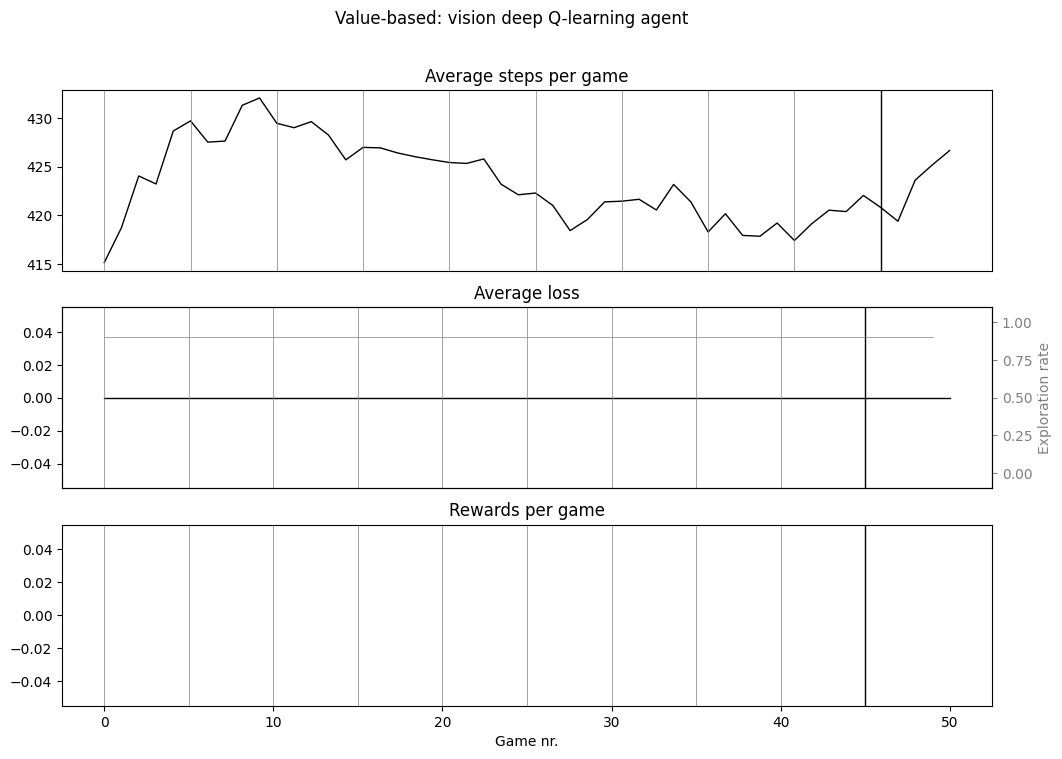

In [8]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i - half_window):min(len(data), i + half_window)]).mean()
            for i in range(len(data))]


STEPS = moving_average(METRICS["steps"])
LOSSES = moving_average(METRICS["losses"])
REWARDS = [val.item() if val > 0 else torch.nan for val in METRICS["rewards"]]

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.suptitle("Value-based: vision deep Q-learning agent")

ax[0].plot(STEPS, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].plot(torch.linspace(0, GAMES, len(LOSSES)), LOSSES, color="black", linewidth=1)
ax[1].set_yscale("log") if any(loss > 0 for loss in LOSSES) else None
ax[1].set_xticks([])
ax[1].set_title("Average loss")

ax_2 = ax[1].twinx()
ax_2.plot(METRICS["exploration"], color="gray", linewidth=0.5)
ax_2.set_ylabel("Exploration rate")
ax_2.yaxis.label.set_color('gray')
ax_2.set_ylim(-0.1, 1.1)
ax_2.tick_params(axis='y', colors='gray')

ax[2].scatter(range(len(REWARDS)), REWARDS, color="black", s=15, marker="*")
ticks = list(set(reward for reward in REWARDS if not torch.isnan(torch.tensor(reward))))
ax[2].set_yticks(ticks) if ticks else None
ax[2].set_xlim(ax[1].get_xlim())
ax[2].set_xlabel("Game nr.")
ax[2].set_title("Rewards per game")

for i in range(0, GAMES, GAMES // 10):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)
    ax[2].axvline(x=i, color='gray', linewidth=0.5)

ax[0].axvline(x=START_TRAINING_AT, color='black', linewidth=1)
ax[1].axvline(x=START_TRAINING_AT, color='black', linewidth=1)
ax[2].axvline(x=START_TRAINING_AT, color='black', linewidth=1)

plt.savefig("./transfer-example.png")

In [9]:
state = torch.tensor(environment.reset()[0], dtype=torch.float32).view(SHAPE)

images = []
TERMINATED = TRUNCATED = False
while not (TERMINATED or TRUNCATED):
    action = value_agent.action(state).item()

    state, reward, TERMINATED, TRUNCATED, _ = environment.step(action)
    state = torch.tensor(state, dtype=torch.float32).view(SHAPE)

    images.append(environment.render())
_ = imageio.mimsave('./transfer-example.gif', images, duration=50)